In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
BASE_DIR = "/Users/akshatha/Spring 2024/Statgenomics/stat555_project"
DIFF_ACC = f"{BASE_DIR}/data/output_data/differential_accessibility/hsc_vs_cfue.tsv"
PEAK_ANNOT = f"{BASE_DIR}/data/output_data/peak_annotation/hsc_vs_cfue.tsv"
GENE_EXP = f"{BASE_DIR}/data/output_data/gene_expression/DE_HSC_vs_CFU.csv"

In [26]:
# read differential chromatin accessibility data
diff_acc = pd.read_csv(DIFF_ACC, sep="\t")
diff_acc["chr_start_end"] = diff_acc["Chr"] + "_" + diff_acc["Start"].astype(str) + "_" + diff_acc["End"].astype(str)
diff_acc.rename(columns={"logFC": "diff_acc_logFC"}, inplace=True)
diff_acc.set_index("chr_start_end", inplace=True)
diff_acc = diff_acc[["diff_acc_logFC"]]

# get genes near differentially accessible peaks
peak_annot = pd.read_csv(PEAK_ANNOT, sep="\t")
peak_annot["chr_start_end"] = peak_annot["seqnames"] + "_" + peak_annot["start"].astype(str) + "_" + peak_annot["end"].astype(str)
peak_annot.set_index("chr_start_end", inplace=True)
peak_annot = peak_annot[["ENSEMBL", "SYMBOL", "annotation", "distanceToTSS", "annotation"]]

# join differential accessibility data with peak annotation data
diff_acc_gene = diff_acc.join(peak_annot)
diff_acc_gene.reset_index(inplace=True)
diff_acc_gene.sort_values("ENSEMBL", inplace=True)
diff_acc_gene.shape

(26538, 7)

In [27]:
genes = diff_acc_gene["ENSEMBL"].unique()
print(len(genes))

12872


In [28]:
# get gene expression data
gene_exp = pd.read_csv(GENE_EXP)
gene_exp.rename(columns={
    "Unnamed: 0": "gene_id",
    "log2FoldChange": "gene_exp_log2FC"
}, inplace=True)
gene_exp["gene_id"] = gene_exp["gene_id"].str.split(".").str[0]
gene_exp = gene_exp[["gene_id", "gene_exp_log2FC"]]

# join gene expression data with differential accessibility data on ENSEMBL and gene ID
diff_acc_gene_exp = diff_acc_gene.merge(gene_exp, left_on="ENSEMBL", right_on="gene_id", how='left')
diff_acc_gene_exp.head()

,chr_start_end,diff_acc_logFC,ENSEMBL,SYMBOL,annotation,distanceToTSS,annotation,gene_id,gene_exp_log2FC
0,chr3_108148021_108148112,-2.003785,ENSMUSG00000000001,Gnai3,Promoter (1-2kb),-1875,Promoter (1-2kb),ENSMUSG00000000001,1.318463
1,chr3_108146027_108146299,-0.720274,ENSMUSG00000000001,Gnai3,Promoter (<=1kb),0,Promoter (<=1kb),ENSMUSG00000000001,1.318463
2,chr16_18812015_18812090,-2.975290,ENSMUSG00000000028,Cdc45,Promoter (<=1kb),-28,Promoter (<=1kb),ENSMUSG00000000028,-1.280409
3,chr16_18811555_18811903,-0.815566,ENSMUSG00000000028,Cdc45,Promoter (<=1kb),0,Promoter (<=1kb),ENSMUSG00000000028,-1.280409
4,chr7_142580303_142580369,-1.597269,ENSMUSG00000000031,H19,Promoter (2-3kb),-2160,Promoter (2-3kb),NaN,NaN


In [29]:
# perform correlation analysis between differential accessibility (diff_acc_logFC) and gene expression (gene_exp_log2FC)
corr = diff_acc_gene_exp[["diff_acc_logFC", "gene_exp_log2FC"]].corr()["diff_acc_logFC"]["gene_exp_log2FC"]
print(corr)

0.36928904436139925


<Axes: xlabel='diff_acc_logFC', ylabel='gene_exp_log2FC'>

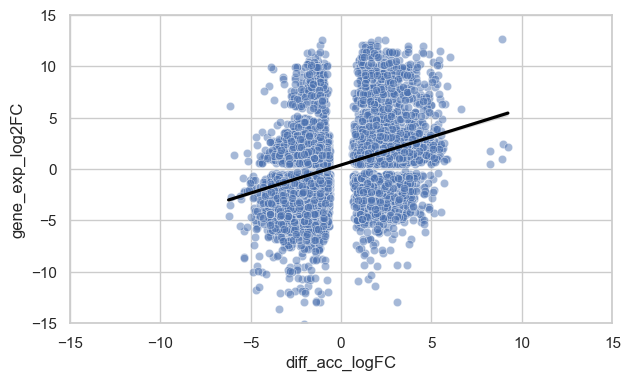

In [30]:
# scatter plot between diff_acc_logFC and gene_exp_log2FC
sns.set(style="whitegrid")
plt.figure(figsize=(7, 4))
sns.scatterplot(
    x="diff_acc_logFC", 
    y="gene_exp_log2FC", 
    data=diff_acc_gene_exp,
    alpha=0.5
)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
# fit a linear regression model
sns.regplot(
    x="diff_acc_logFC", 
    y="gene_exp_log2FC", 
    data=diff_acc_gene_exp,
    scatter=False,
    color='black'
)
